In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
from matplotlib import patches
import sqlite3 as db
import os
import blender_config as cng
from typing import Iterable, Callable, Sequence, List, Dict, Optional
from skimage import io

In [2]:
for var, val in cng.__dict__.items():
    if (val is not None) and not var.startswith('_'):
        print(f"{var} = {val}") 

pi = 3.141592653589793
SRC_CLTN = Fishes
TRGT_CLTN = Copies
REF_CLTN = Reference
SPAWNBOX_OBJ = spawnbox
CAMERA_OBJ = Camera
ROT_MUS = [1.5707963267948966, 0, 3.141592653589793]
ROT_STDS = [0.5, 1, 1]
DEFAULT_BBOX_MODE = xyz
COMMIT_INTERVAL = 32
GENERATED_DATA_DIR = generated_data
IMAGE_DIR = images
IMAGE_NAME = img
DEFAULT_FILEFORMAT = PNG
DEFAULT_FILEFORMAT_EXTENSION = .png
BBOX_DB_FILE = bboxes.db
METADATA_FILE = metadata.txt
BBOX_DB_IMGRNR = imgnr
BBOX_DB_CLASS = class_
BBOX_MODE_CPS = cps
BBOX_MODE_XYZ = xyz
BBOX_MODE_STD = std
BBOX_DB_TABLE_XYZ = bboxes_xyz
BBOX_DB_TABLE_CPS = bboxes_cps
BBOX_DB_TABLE_STD = bboxes_std
FILE_SUFFIX_LEFT = _L
FILE_SUFFIX_RIGHT = _R
ARGS_DEFAULT_ENGINE = CYCLES
ARGS_DEFAULT_DEVICE = CUDA
ARGS_DEFAULT_RENDER_SAMPLES = 96
ARGS_DEFAULT_BBOX_MODE = all
ARGS_DEFAULT_VIEW_MODE = stereo
HIGHLIGHT_MIN_WIDTH = 70
BOXED_SYMBOL_TOP = =
BOXED_SYMBOL_BOTTOM = =
BOXED_STR_SIDE = ||
SECTION_SYMBOL = -
SECTION_START_STR = 
SECTION_END_STR = 



In [40]:
class BlenderData:
    def __init__(self, data_dir: str):
        self.data_dir = data_dir
        self.sqlite_file = os.path.join(data_dir, cng.BBOX_DB_FILE)
        self.image_dir = os.path.join(data_dir, cng.IMAGE_DIR)
        self.con = db.connect(f'file:{self.sqlite_file}?mode=ro', uri=True)
        
        with open(os.path.join(data_dir, cng.METADATA_FILE)) as f:
            self.num2name = eval(f.readline())
        
    def query(self, q: str) -> pd.DataFrame:
        return pd.read_sql_query(q, self.con)
    
    def get_image(self, imgnr: int, suffixes: Sequence[str]):
        imgs = []
        for suffix in suffixes:
            try:
                imgs.append(io.imread(os.path.join(
                    self.image_dir, f'{cng.IMAGE_NAME}{imgnr}{suffix}{cng.DEFAULT_FILEFORMAT_EXTENSION}')
                ))
            except FileNotFoundError as e:
                imgs.append(None)
        return imgs
    
    def plot_std_bboxes(self, imgnr: int, suffix: str, ax: Optional['Axes'] = None):
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(7,5))
        else:
            ax = plt.gca()
        
        img = self.get_image(imgnr, [suffix])[0]
        img_h, img_w = img.shape[:-1]
        bboxes = self.query(
            f'SELECT class_, x, y, w, h FROM bboxes_std WHERE imgnr == {imgnr}'
        ).values
        
        ax.imshow(img)
        
        for class_, x, y, w, h in bboxes:
            topLeftCorner = (x*img_h, y*img_w)
            ax.add_patch(patches.Rectangle(topLeftCorner, w*img_w, h*img_h, facecolor='none', edgecolor='red', linewidth=2))
            ax.text(x=topLeftCorner[0], y=topLeftCorner[1], s=self.num2name[int(class_)], bbox=dict(facecolor='red', alpha=0.7))

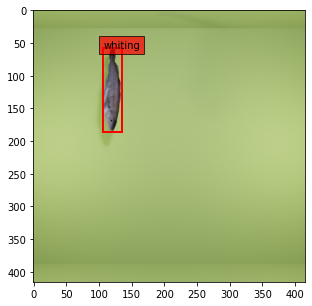

In [45]:
data = BlenderData(cng.GENERATED_DATA_DIR)
data.plot_std_bboxes(19, '')